In [1]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

# Keras imports
from keras.models import Model
from keras import backend as K

# ML4CVD Imports
sys.path.append("../ml4cvd")
from arguments import parse_args
from models import make_multimodal_to_multilabel_model, train_model_from_generators
from tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def gradients_from_output(args, model, output_layer, output_index):
    K.set_learning_phase(1)
    input_tensor = model.input
    x = model.get_layer(output_layer).output[:,output_index]
    grads = K.gradients(x, input_tensor)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6) # normalization trick: we normalize the gradient
    iterate = K.function([input_tensor], [x, grads])
    return iterate

def saliency_map(input_tensor, model, output_layer, output_index):
    get_gradients = gradients_from_output(args, model, output_layer, output_index)
    activation, grads = get_gradients([input_tensor])
    print('Activation is:', activation, 'gradient shape:', grads.shape)
    return grads


In [3]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'end_systole_volume',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_esv.hd5',
            '--id', 'mri_slice_esv']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-08 00:24:24,455 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_esv/log_2019-05-08_00-24_0.log.
2019-05-08 00:24:24,457 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773, 3

2019-05-08 00:24:36,045 - tensor_generators:222 - INFO - Input tensor 'input_mri_slice' has shape (6, 256, 256, 1)
2019-05-08 00:24:36,046 - tensor_generators:225 - INFO - Output tensor 'output_end_systole_volume_continuous' has shape (6, 1)


(6, 256, 256, 1) (1, 256, 256, 1)


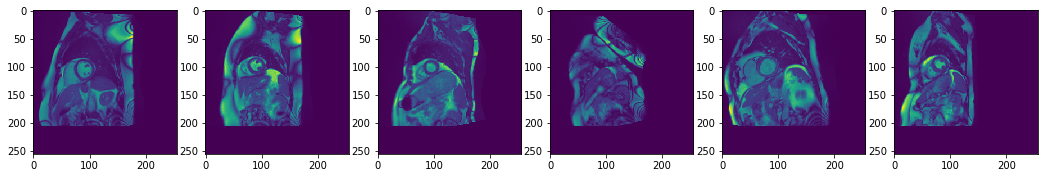

In [4]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

Activation is: [1.1257458  0.03877224 1.6049327  0.54763424 2.8795533  0.07079139] gradient shape: (6, 256, 256, 1)


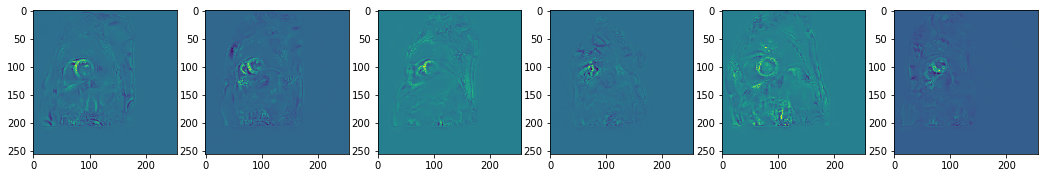

In [5]:
grads = saliency_map(test_tensor, model, 'output_end_systole_volume_continuous', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [6]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'bmi',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_bmi.hd5',
            '--id', 'mri_slice_bmi']

args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-08 00:24:40,077 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_bmi/log_2019-05-08_00-24_0.log.
2019-05-08 00:24:40,079 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773, 3

2019-05-08 00:24:44,381 - tensor_generators:222 - INFO - Input tensor 'input_mri_slice' has shape (6, 256, 256, 1)
2019-05-08 00:24:44,383 - tensor_generators:225 - INFO - Output tensor 'output_23104_Body-mass-index-BMI_0_0_continuous' has shape (6, 1)


(6, 256, 256, 1) (1, 256, 256, 1)


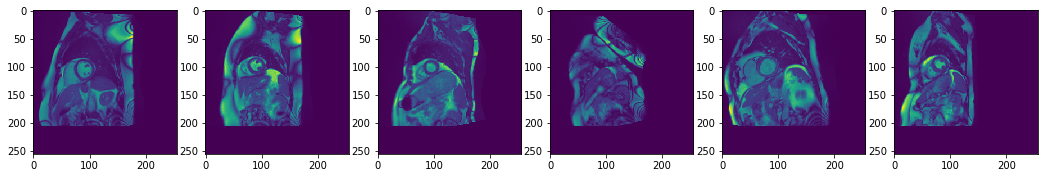

In [7]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

Activation is: [ 0.7504341   0.21536857 -0.28221422 -0.30789512  0.31855908 -0.55254364] gradient shape: (6, 256, 256, 1)


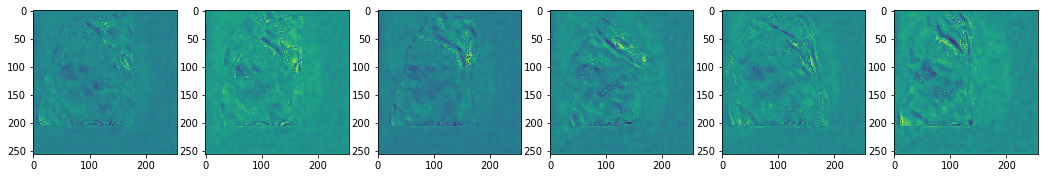

In [8]:
grads = saliency_map(test_tensor, model, 'output_23104_Body-mass-index-BMI_0_0_continuous', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [9]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'genetic_sex',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_sex.hd5',
            '--id', 'mri_slice_sex']

args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-08 00:24:46,978 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_sex/log_2019-05-08_00-24_0.log.
2019-05-08 00:24:46,983 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773, 3

2019-05-08 00:24:51,610 - tensor_generators:222 - INFO - Input tensor 'input_mri_slice' has shape (6, 256, 256, 1)
2019-05-08 00:24:51,611 - tensor_generators:225 - INFO - Output tensor 'output_genetic_sex_categorical' has shape (6, 2)


(6, 256, 256, 1) (1, 256, 256, 1)


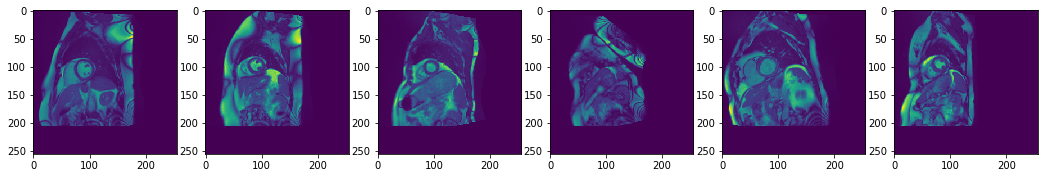

In [10]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

Activation is: [9.98785436e-01 9.99973178e-01 1.95289758e-05 9.84996080e-01
 1.32585465e-05 9.99334872e-01] gradient shape: (6, 256, 256, 1)


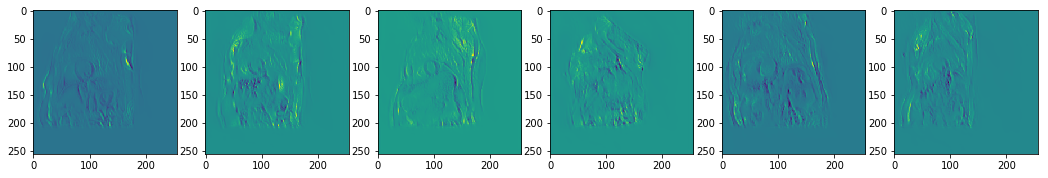

In [11]:
grads = saliency_map(test_tensor, model, 'output_genetic_sex_categorical', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [12]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'birth_year',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_age.hd5',
            '--id', 'mri_slice_age']

args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-08 00:26:05,655 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_age/log_2019-05-08_00-26_0.log.
2019-05-08 00:26:05,656 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773, 3

2019-05-08 00:26:15,311 - tensor_generators:222 - INFO - Input tensor 'input_mri_slice' has shape (6, 256, 256, 1)
2019-05-08 00:26:15,312 - tensor_generators:225 - INFO - Output tensor 'output_22200_Year-of-birth_0_0_continuous' has shape (6, 1)


(6, 256, 256, 1) (1, 256, 256, 1)


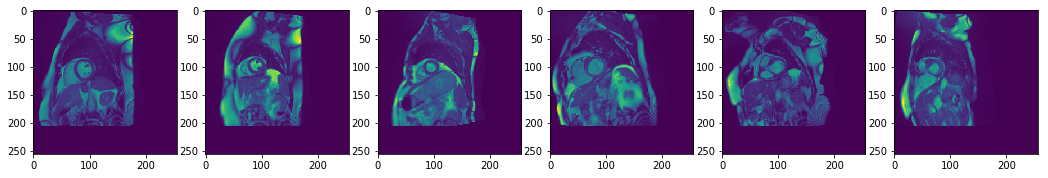

In [13]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(test_tensor[i, :, :, 0]) for i in range(6)]

Activation is: [-0.25995582 -0.03492614 -0.18111314 -0.31288496  0.03840538 -0.05968263] gradient shape: (6, 256, 256, 1)


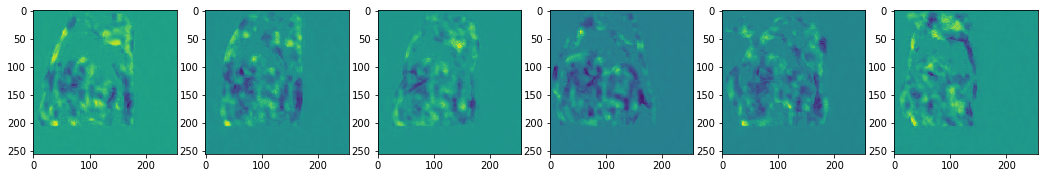

In [14]:
grads = saliency_map(test_tensor, model, 'output_22200_Year-of-birth_0_0_continuous', 0)
_, axes = plt.subplots(1, 6, figsize=(18, 14))
[axes[i].imshow(grads[i, :, :, 0]) for i in range(6)]

In [9]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_systole_diastole', 
            '--output_tensors', 'end_systole_volume',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_systole_diastole_esv.hd5',
            '--id', 'mri_systole_diastole_esv']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)


2019-05-07 22:59:13,671 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_systole_diastole_esv/log_2019-05-07_22-59_0.log.
2019-05-07 22:59:13,674 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 36

2019-05-07 22:59:24,032 - tensor_generators:222 - INFO - Input tensor 'input_mri_systole_diastole' has shape (6, 256, 256, 2, 1)
2019-05-07 22:59:24,033 - tensor_generators:225 - INFO - Output tensor 'output_end_systole_volume_continuous' has shape (6, 1)


(6, 256, 256, 2, 1) (1, 256, 256, 2, 1)


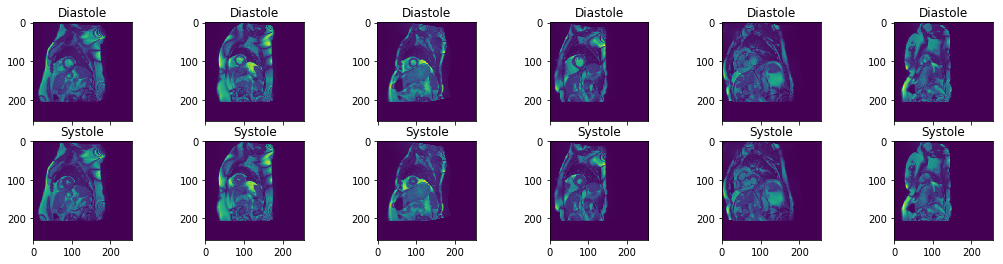

In [10]:
test_tensor = test_data['input_mri_systole_diastole']
print(test_tensor.shape, test_tensor[:1].shape)
_, axes = plt.subplots(2, 6, figsize=(18, 4), sharex=True)
for i in range(6):
    axes[0, i].set_title('Diastole')
    axes[1, i].set_title('Systole')
    axes[0, i].imshow(test_tensor[i, :, :, 0, 0])
    axes[1, i].imshow(test_tensor[i, :, :, 1, 0])
    

Activation is: [0.64319247 0.70740354 1.5593781  0.23088326 1.8311199  0.2544826 ] gradient shape: (6, 256, 256, 2, 1)


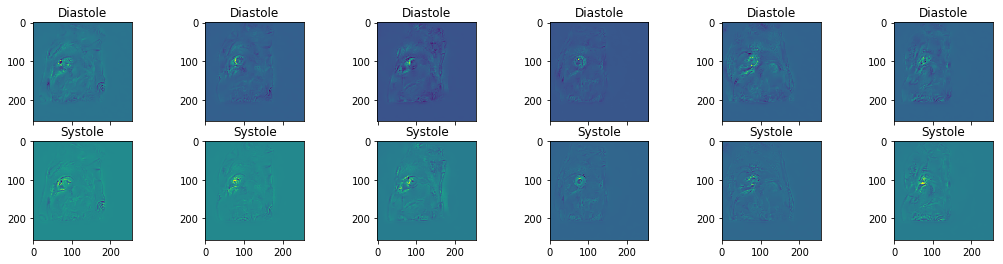

In [11]:
grads = saliency_map(test_tensor, model, 'output_end_systole_volume_continuous', 0)
_, axes = plt.subplots(2, 6, figsize=(18, 4), sharex=True)
for i in range(6):
    axes[0, i].set_title('Diastole')
    axes[1, i].set_title('Systole')
    axes[0, i].imshow(grads[i, :, :, 0, 0])
    axes[1, i].imshow(grads[i, :, :, 1, 0])
    

In [ ]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/ecg-text3/2019-04-26/', 
            '--input_tensors', 'ecg_rest_1lead', 
            '--output_tensors', 'ecg_rhythm',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/home/sam/ml/trained_models/ecg_1lead_rhythm_only/ecg_1lead_rhythm_only.hd5',
            '--id', 'ecg_1lead_rhythm_only']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

In [ ]:
test_tensor = test_data['input_strip_ecg_rest']
print(test_tensor.shape, test_tensor[3:4].shape)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(test_tensor[i,:,:].flatten('F')) for i in range(6)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 0)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(6)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 3)
_, axes = plt.subplots(6, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(6)]

In [ ]:
xdir = '/mnt/disks/ecg-text3/2019-04-26/'
paths = [xdir+'1238558.hd5', xdir+'1258475.hd5', xdir+'1286494.hd5', xdir+'1381627.hd5', 
         xdir+'1487911.hd5', xdir+'1509361.hd5', xdir+'1578315.hd5', xdir+'1616127.hd5', xdir+'1723645.hd5', ]
generator = TensorGenerator(8, args.tensor_maps_in, args.tensor_maps_out, paths, None, True)
data, labels, hd5s = next(generator)
print('predicitons are:', model.predict(data))

In [ ]:
test_tensor = data['input_strip_ecg_rest']
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(test_tensor[i,:,:].flatten('F')) for i in range(8)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 3)
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(8)]

In [ ]:
grads = saliency_map(test_tensor, model, 'output_ecg_rhythm_categorical', 0)
_, axes = plt.subplots(8, 1, figsize=(18, 14))
[axes[i].plot(grads[i,:,:].flatten('F')) for i in range(8)]

In [ ]:
grads = saliency_map(test_tensor[7:8], model, 'output_ecg_rhythm_categorical', 2)

In [ ]:
grads = saliency_map(test_tensor[7:8], model, 'output_ecg_rhythm_categorical', 0)